# Constants

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment

you can use `0_preprocess_midi-gm.ipynb` to process your own MIDI data.

or you can download preprocessed pianoroll data of lots of drum patterns and place them in `./data/`. 
https://drive.google.com/drive/folders/1IjcSNACkleZKe7AF-FO_RefKvOWwN8NH?usp=sharing

In [2]:
from rhythm_can.constants import *
from rhythm_can.utils import *
%matplotlib inline

print("DRUM_CLASSES:", DRUM_CLASSES)
print("# of drum instruments:", nb_notes)

print("dimentionality of random input z:", len_input)
print("resolution of one bar:", resolution*4) # how many grids in one bar
print("length of rhythm pattern to be generated:", len_seq, "beats" )


DRUM_CLASSES: ['Kick', 'Snare', 'Hi-hat closed', 'Hi-hat open', 'Low Tom', 'High Tom', 'Cymbal', 'Clap/Cowbell', 'Rim']
# of drum instruments: 9
dimentionality of random input z: 150
resolution of one bar: 24
length of rhythm pattern to be generated: 48 beats


# Training

In [3]:
import numpy as np

matrices_onsets = np.load("./data/matrices_drum_gm_clean_grid48.npz")['onsets']
matrices_velos = np.load("./data/matrices_drum_gm_clean_grid48.npz")['velocities']
matrices_offsets = np.load("./data/matrices_drum_gm_clean_grid48.npz")['offsets']
matrices_genres = np.load("./data/matrices_drum_gm_clean_grid48.npz")['genre_ids']

GENRES = np.load("./data/matrices_drum_gm_clean_grid48.npz")['genres']
NB_GENRES = len(GENRES)

print("Genres", GENRES)
print("# of Genres", NB_GENRES)
print(matrices_onsets.shape)

Genres ['dnb' 'house' 'garage' 'trance' 'techno' 'jungle' 'breakbeat'
 'percussion' 'downtempo' 'old_skool']
# of Genres 10
(3410, 48, 9)


breakbeat


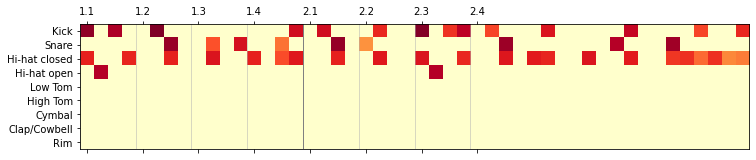

downtempo


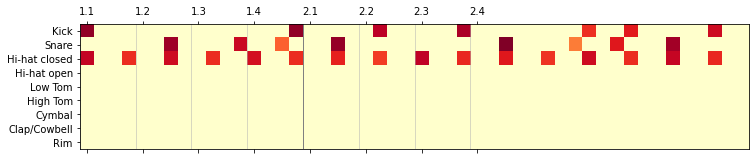

house


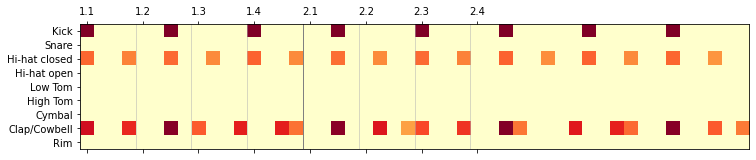

breakbeat


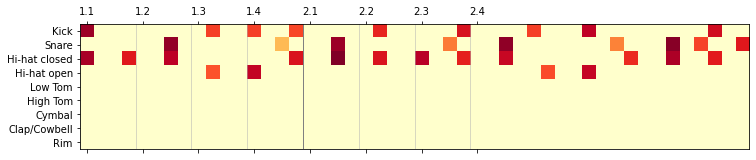

old_skool


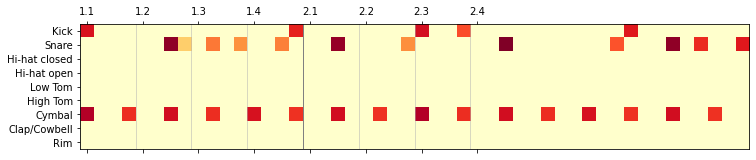

garage


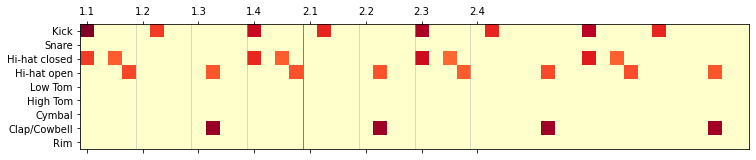

old_skool


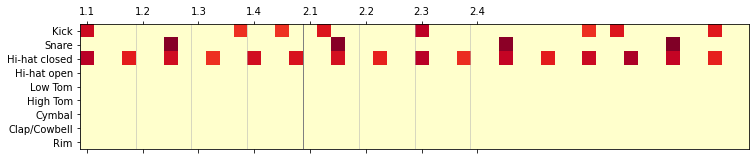

breakbeat


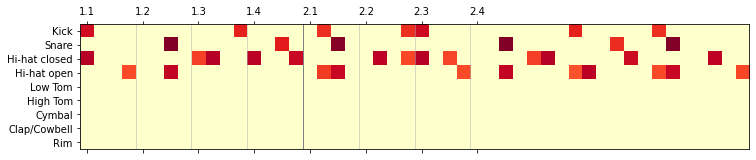

dnb


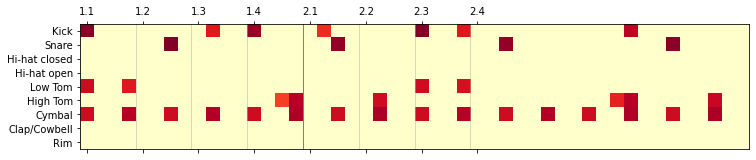

dnb


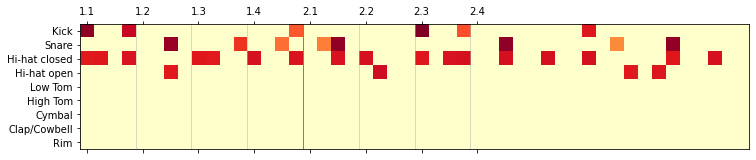

In [4]:
import random
# plot_drum_matrix(random.choice(matrices_onsets))

for _ in range(10):
    index = random.choice(range(matrices_genres.shape[0]))
    print(GENRES[matrices_genres[index]])
    plot_drum_matrix(matrices_velos[index])
    play_drum_matrix(matrices_velos[index])
#plot_drum_matrix(random.choice(matrices_offsets))


In [5]:
# weight for genre classification loss and GAN loss
loss_weights = [1., 1/np.sqrt(NB_GENRES)]
print(loss_weights)

[1.0, 0.31622776601683794]


## Discriminator

In [6]:
import numpy as np
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate, Softmax
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential
from keras import regularizers


droprate = 0.1

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(drum_input) 
x0 = BatchNormalization()(x0)
x0 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x0)
x0 = BatchNormalization()(x0)

x0 = Dropout(droprate)(x0)
x0 = Dense(512, activation='sigmoid')(x0)
genre_output = Dense(NB_GENRES, activation='softmax', name='style_output',
               kernel_regularizer=regularizers.l2(0.01), 
               activity_regularizer=regularizers.l1(0.01))(x0)


# # Conditioning label:
# # Integer 0-NB_GENRES denoting the genre G should generate
# label_input = Input(shape=(1,), dtype='int32')

# # Embedding layer:
# # Turns labels into dense vectors of size z_dim
# # Produces 3D tensor with shape: (batch_size, 1, 28*28*1)
# label_embedding = Embedding(NB_GENRES, np.prod((len_seq, nb_notes)), input_length=1)(label_input)

# # Flatten the embedding 3D tensor into 2D tensor with shape:(batch_size, 28*28*1)
# label_embedding = Flatten()(label_embedding)

# # Reshape label embeddings to have same dimensions as input images
# label_embedding = Reshape((len_seq, nb_notes))(label_embedding)

# # Concatenate images with corresponding label embeddings
# concatenated = Concatenate(axis=-1)([drum_input, label_embedding])

x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(64, return_sequences=False, activation='tanh'))(x)
# x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
# x = Reshape((1024,))(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
gan_output = Dense(1, activation='sigmoid', name='gan_output')(x)

discriminator_c = Model(drum_input, [gan_output,genre_output])
discriminator_c.summary()

optimizer = Adam(lr=0.00001) 
discriminator_c.compile(optimizer=optimizer, loss={'gan_output':'binary_crossentropy','style_output':'categorical_crossentropy'},
                      loss_weights=loss_weights,
                    metrics={'gan_output':'binary_accuracy', 'style_output':'categorical_accuracy'})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 48, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 48, 256)      141312      drum_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 256)      1024        bidirectional_1[0][0]            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 48, 128)      37888       drum_input[0][0]                 
____________________________________________________________________________________________

In [7]:
# # temporary model 
# discriminator_a = Model(drum_input, gan_output)
# discriminator_a.summary()

# optimizer = Adam() # higher leraning rate for D
# discriminator_a.compile(optimizer=optimizer, 
#                         loss={'gan_output':'binary_crossentropy'},
#                     metrics={'gan_output':'binary_accuracy'})

In [8]:
# from keras.models import load_model

# classifier = load_model("./tmp/onset_classification_gm_14-0.69.hdf5")
# classifier.summary()


In [9]:
# j = 0

# for i, layer in enumerate(classifier.layers):
#     print (i, layer)
    
# for i, layer in enumerate(discriminator_c.layers):
#     print (i, layer)
    
#     if i <= 4 or layer not in discriminator_a.layers:    
#         w = classifier.layers[j].get_weights()
#         layer.set_weights(w)
# #        layer.trainable = False # freezes the layer
#         j += 1

In [10]:
print (discriminator_c.metrics_names)

['loss', 'gan_output_loss', 'style_output_loss', 'gan_output_binary_accuracy', 'style_output_categorical_accuracy']


## GENERATOR 

In [11]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,Embedding,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

z_input = Input(shape=(len_input,))  # tensorflow order

# # Conditioning label
# label_input = Input(shape=(1,), dtype='int32')
# label_embedding = Embedding(NB_GENRES, len_input, input_length=1)(label_input)
# label_embedding = Flatten()(label_embedding)

# # Element-wise product of the vectors z and the label embeddings
# inputs2 = multiply([z_input, label_embedding])

# 
x = Dense(512)(z_input)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Dense(len_seq * 32)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((len_seq, 32))(x)
x = Dropout(droprate)(x)

x = LSTM(128, return_sequences=True, activation='tanh')(x) 
x = LSTM(128, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)

generator = Model(z_input, note_out)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               77312     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 1536)              787968    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1536)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1536)              6144

In [12]:
# j = 0

# for i, layer in enumerate(generator_tmp.layers):
#     print (i, layer)

# for i, layer in enumerate(generator.layers):
#     print(i, layer)
    
# for i, layer in enumerate(discriminator_c.layers):
#     print (i, layer)
    
#     if i <= 4 or layer not in discriminator_a.layers:    
#         w = classifier.layers[j].get_weights()
#         layer.set_weights(w)
# #        layer.trainable = False # freezes the layer
#         j += 1

## ADVERSARIAL MODEL 

In [13]:
def style_ambiguity_loss(y_true, y_pred):
    even_dist = K.ones_like(y_pred) * 1.0/float(len(GENRES))
    return K.categorical_crossentropy(even_dist, y_pred, from_logits=False)

In [14]:

# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
# label_input = Input(shape=(1,), dtype='int32')
img_gan = generator(z_input)

# training is disable for discriminator in adversarial model
discriminator_c.trainable = False 

# define output
prediction_gan = discriminator_c(img_gan)
print(prediction_gan)

# define combined GAN model
gan = Model(z_input, prediction_gan)
optimizer = Adam(lr=0.0001)
gan.compile(optimizer=optimizer, loss=['binary_crossentropy', style_ambiguity_loss], 
            loss_weights=loss_weights, metrics=['binary_accuracy'])
gan.summary()


[<tf.Tensor 'model_1/gan_output/Sigmoid:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'model_1/style_output/Softmax:0' shape=(?, 10) dtype=float32>]
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
model_2 (Model)              (None, 48, 9)             1092456   
_________________________________________________________________
model_1 (Model)              [(None, 1), (None, 10)]   844299    
Total params: 1,936,755
Trainable params: 1,088,360
Non-trainable params: 848,395
_________________________________________________________________


In [15]:
gan.metrics_names

['loss',
 'model_1_loss',
 'model_1_loss',
 'model_1_binary_accuracy',
 'model_1_binary_accuracy_1']

## Training

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 0.50, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  
        

def play_drum_matrix(mat, tempo=120.0, threshold=0.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120., threshold=0.0):
    
    
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data






In [17]:
matrices_onsets = matrices_velos

epoch 495 0
d_loss 0.6179662942886353 d_cat_acc 0.9739583333333334 a_loss 0.8236516 a_cat_loss 2.65505
d_accuracy 0.7291666666666666


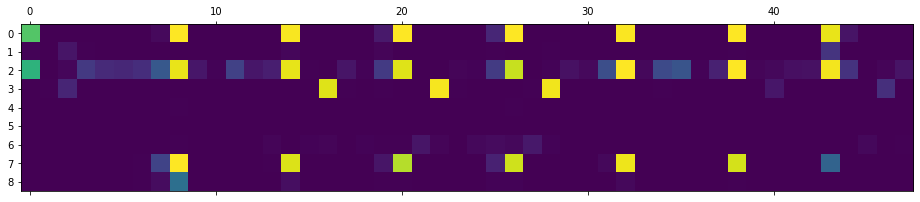

epoch 496 0
d_loss 0.6343574921290079 d_cat_acc 0.9791666666666666 a_loss 0.7109995 a_cat_loss 2.6587892
d_accuracy 0.7213541666666666


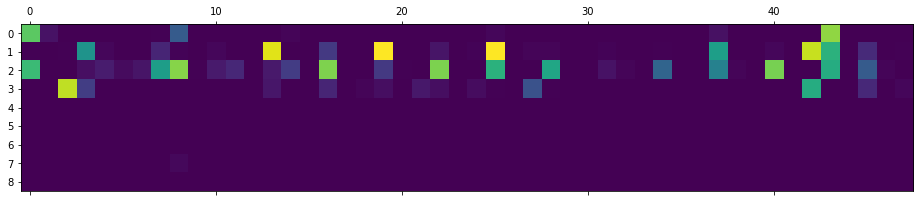

epoch 497 0
d_loss 0.6751741766929626 d_cat_acc 0.9791666666666666 a_loss 0.7810913 a_cat_loss 2.6513386
d_accuracy 0.5859375


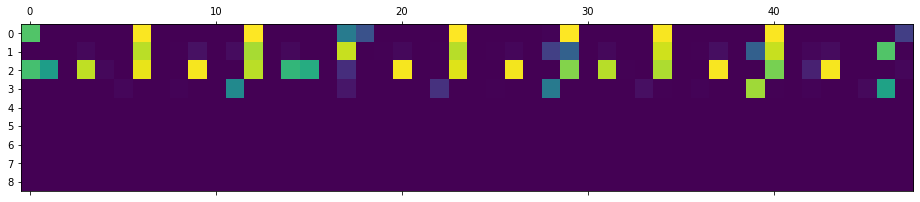

epoch 498 0
d_loss 0.6259221831957499 d_cat_acc 1.0 a_loss 0.79199106 a_cat_loss 2.6656208
d_accuracy 0.6822916666666666


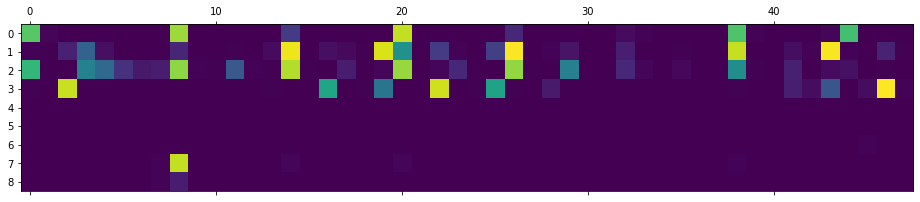

epoch 499 0
d_loss 0.55535360177358 d_cat_acc 0.9895833333333334 a_loss 0.8611574 a_cat_loss 2.672258
d_accuracy 0.75


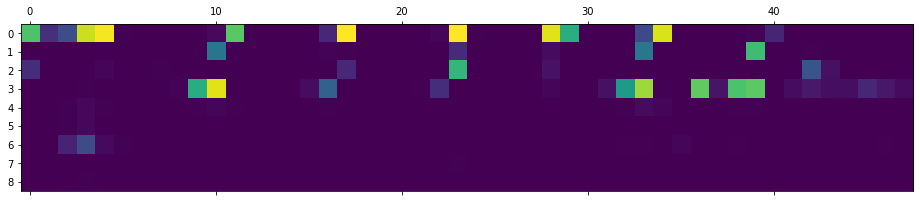

In [18]:
from keras.utils import to_categorical 

import os
os.makedirs('./tmp', exist_ok=True)

# Start logging with TensorBoard
start_tfboard_log(logdir_prefix = "/tmp/tf_logs_can/")

batch_size = 64
nb_epochs = 500
K_unrolled = 3         # train D (K_unrolled) times per 1 training for G
MAX_LOSS_RATIO = 5.0   # temporarily pause training when the ratio of losses of D and G 
                       # gets more than (MAX_LOSS_RATIO)

# total number of samples
nb_samples = matrices_onsets.shape[0]

# Labels for real drums: all ones
real_labels = np.ones((batch_size, 1)) # * 0.9 #you can try one-sided soft labeling for better stability

# Labels for fake drums: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

# keep track of min total loss
min_total_loss = 100000. 
min_total_loss_epoch = 0

for epoch in range(0, nb_epochs):
    nb_steps = int(nb_samples/batch_size)
    
    for repeat in range(nb_steps):
        
        step = nb_steps * epoch + repeat
        
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            m_d_accuracy_fake = 0.0
            m_d_accuracy_real = 0.0
            m_d_loss_cat = 0.0
            m_d_cat_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_onsets.shape[0], size=batch_size)
                drum_train = matrices_onsets[random_indices, :, :]
                labels_traing = matrices_genres[random_indices]
                labels_traing_categorical = to_categorical(labels_traing, num_classes=NB_GENRES)

                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict(noise)

                # training D
                _, d_loss_real, d_loss_cat, d_acc_real, cat_accuracy = discriminator_c.train_on_batch(drum_train,
                                                                    [real_labels, labels_traing_categorical]) 
                _, d_loss_fake, _, d_acc_fake, _ = discriminator_c.train_on_batch(drum_fake,
                                                                [fake_labels, labels_traing_categorical]) 
                #print(d_acc_real, d_acc_fake, cat_accuracy)
                
                m_d_loss += 0.5 * (d_loss_real + d_loss_fake)
                m_d_loss_cat += d_loss_cat
                m_d_accuracy +=  0.5 * (d_acc_real + d_acc_fake)
                m_d_accuracy_fake += d_acc_fake
                m_d_accuracy_real += d_acc_real
                m_d_cat_accuracy += cat_accuracy
                # cache for later update
    #             cache_weights = discriminator.get_weights()
            
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            m_d_accuracy_fake /= float(K_unrolled)
            m_d_accuracy_real /= float(K_unrolled)
            m_d_loss_cat /= float(K_unrolled)
            m_d_cat_accuracy /= float(K_unrolled)
           
            # store value
            log_value("D loss", m_d_loss, step)  
            log_value("D accuracy", m_d_accuracy, step)  
            log_value("D accuracy - fake", m_d_accuracy_fake, step) 
            log_value("D accuracy - real", m_d_accuracy_real, step) 
            
            log_value("D category loss", m_d_loss_cat, step)  
            log_value("D category accuracy", m_d_cat_accuracy, step) 
            log_value("D total loss", m_d_loss + m_d_loss_cat, step)
            
            
            
        # training G
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)

            # Get a batch of random labels
            labels_random = np.random.randint(0, NB_GENRES, batch_size).reshape(-1, 1)
            labels_random_categorical = to_categorical(labels_random, num_classes=NB_GENRES)
                
            _, m_a_loss, m_a_cat_loss, m_a_accuracy, _ = gan.train_on_batch(noise, [y, labels_random_categorical])
            
            # store value
            log_value("G loss", m_a_loss, step)
            log_value("G accuracy", m_a_accuracy, step)
            log_value("style amguity loss", m_a_cat_loss, step)
            log_value("G total loss", m_a_loss + m_a_cat_loss, step)
        
        if train_d and train_g:
            
            total_los = m_a_loss + m_a_cat_loss + m_d_loss + m_d_loss_cat
            if total_los < min_total_loss:
                min_total_loss = total_los
                min_total_loss_epoch = epoch
                generator.save("./tmp/can_iccc-generator.h5")
            
            if m_a_loss / m_d_loss > MAX_LOSS_RATIO:
                train_d = False
                train_g = True
#                print("Pausing D")
            elif m_d_loss / m_a_loss > MAX_LOSS_RATIO:
                train_g = False
                train_d = True
#                print("Pausing G")
        else:
            train_d = True
            train_g = True
            
 
        if repeat % 100 == 0:
            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "d_cat_acc", m_d_cat_accuracy,
                "a_loss", m_a_loss, 'a_cat_loss', m_a_cat_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
            
            # sample output
            noise = get_noise(1, len_input)
            labels_random = np.random.randint(0, NB_GENRES, 1).reshape(-1, 1)
            drum_generated = generator.predict([noise])           
            plot_drum_matrix(drum_generated)
            
            # sample audio output
            audio_data = play_drum_matrix(np.squeeze(drum_generated))
            #wavfile.write("audio/drum_%05d_%05d.wav" % (epoch, repeat), 44100, audio_data)
            
            print
            print
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/can_iccc_generator-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        #gan.save("./tmp/can2_pretrain_gan-epoch-%03d-%0.5f.h5" % (epoch, m_a_loss))
        #discriminator_c.save("./tmp/can2_pretrain_discriminator_c-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))
        clear_output(wait=True)

In [ ]:
from keras.models import load_model


generator = load_model("./tmp/can_iccc_generator-epoch-094-0.92749.h5")

In [ ]:
import time


for i in range(10):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)
    audio_data, _ = play_drum_matrix(np.squeeze(drum_generated))
    #midifile.write("./midi/output-%s.mid" % time.time())
    wavfile.write("audio/drum_%05d_%05d.wav" % (epoch, repeat), 44100, audio_data)